# Анализ поведения и группирование пользователей приложения "Ненужные вещи"

# Описание проекта

Пользователи приложения совершают множество действий. Необходимо найти инсайты, которые помогут приложению лучшим. Также, нужно выделить различные группы пользователей по характеру действий (например, по каналу привлечения) и понять, как это можно использовать. Еще имеются более конкретные вопросы про группы:

- Пользователи какой группы склонны возвращаться?
- Пользователи какой группы чаще делают целевое действие?
- Как различается время между распространенными события разных групп?

Ссылка на презентацию: https://drive.google.com/file/d/186mSZ91t6uU_JIxw_WJjrSmdj0Gks-0m/view?usp=sharing

# Загрузка и обзор данных

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="white", font_scale=1.5)
pd.options.display.max_colwidth = 1 

### Загрузка и обзор датасетов

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

print('mobile_sourсes')
display(mobile_sourсes.head())
mobile_sourсes.info()
print('')
print('mobile_dataset')
display(mobile_dataset.head())
mobile_dataset.info()

mobile_sourсes


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB

mobile_dataset


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Таблицы выглядят нормально, пропусков нет. Все типы данных, крмое времени соответствуют значениям в таблицах. Мы имеем 4293 пользователя и 74197 событий.

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

# Предобработка данных

### Переименовать колонки

In [3]:
mobile_sourсes = mobile_sourсes.rename(columns={'userId':'user_id'})
mobile_dataset.columns = mobile_dataset.columns.str.replace(r'.','_', regex=True)

In [4]:
print(mobile_sourсes.columns)
print(mobile_dataset.columns)

Index(['user_id', 'source'], dtype='object')
Index(['event_time', 'event_name', 'user_id'], dtype='object')


Теперь названия колонок приведены к единому стилю.

### Привести типы

In [5]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Колонка с датой и временем теперь в нужном формате.

### Исследовать пропущенные значения

In [6]:
print(f'Пропусков в mobile_dataset: {mobile_dataset.isna().sum()}')
print(f'Пропусков в mobile_sourсes: {mobile_sourсes.isna().sum()}')

Пропусков в mobile_dataset: event_time    0
event_name    0
user_id       0
dtype: int64
Пропусков в mobile_sourсes: user_id    0
source     0
dtype: int64


Пропусков нет.

### Исследовать дубликаты

In [7]:
print(f'Дубликатов в mobile_sourсes: {mobile_sourсes.duplicated().sum()}')
print(f'Дубликатов в mobile_dataset: {mobile_dataset.duplicated().sum()}')

Дубликатов в mobile_sourсes: 0
Дубликатов в mobile_dataset: 0


Дубликаты отсутствуют.

### Исследовать уникальные значения

In [8]:
mobile_dataset = mobile_dataset.replace('show_contacts','contacts_show')

print(mobile_dataset['event_name'].value_counts())

tips_show        40055
photos_show      10012
advert_open      6164 
contacts_show    4529 
map              3881 
search_1         3506 
favorites_add    1417 
search_5         1049 
tips_click       814  
search_4         701  
contacts_call    541  
search_3         522  
search_6         460  
search_2         324  
search_7         222  
Name: event_name, dtype: int64


Уникальных пользователей: 4293. 3 канала привлечения. 74197 событий. 15 типов событий. И всё те же 4293 юзера во второй таблице. Можно объединять.

### Объединение таблиц

In [9]:
print(mobile_dataset['user_id'].count() - mobile_dataset['user_id'].isin(mobile_sourсes['user_id']).count())

0


In [10]:
data = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left')
print('Ункальных значений user_id: {} '.format(len(data['user_id'].unique())))

Ункальных значений user_id: 4293 


Таблицы объединены в одну.

# Исследовательский анализ данных

### Взглянуть на подготовленные данные

Посмотрим, что получилось, всё ли на месте.

In [11]:
display(data.head())
data.info()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


Всё выглядит хорошо, пропусков нет, типы данных соответствующие.

In [12]:
print('Дата начала исследования {}'.format(data['event_time'].min()))
print('Дата конца исследования {}'.format(data['event_time'].max()))

Дата начала исследования 2019-10-07 00:00:00.431357
Дата конца исследования 2019-11-03 23:58:12.532487


### Определить сессии пользователей

Для разделения действий по сессиям, воспользуемся правилом: если пользователь ничего не делал 20 минут, то последнее действие- это конец сессии.

In [13]:
df = data.sort_values(['user_id', 'event_time'])

diff_timestamp = (
    df
    .groupby('user_id')['event_time']
    .diff()
    .dt.total_seconds()
    .round()
)

new_session = (diff_timestamp.isnull()) | (diff_timestamp > 1200)

df['session'] = df.loc[new_session, ['user_id', 'event_time']] \
    .groupby('user_id').rank(method='first').astype(int)

data['session'] = df['session'].fillna(method='ffill').astype(int)

display(data.sort_values(by=['user_id', 'event_time']).head(15))

,event_time,event_name,user_id,source,session
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2


Как видно, у каждого пользователя теперь есть номер сессии (начинается с '1' для каждого юзера).

### Найти и проанализировать выбросы

Проверим распределение пользователей по источникам.

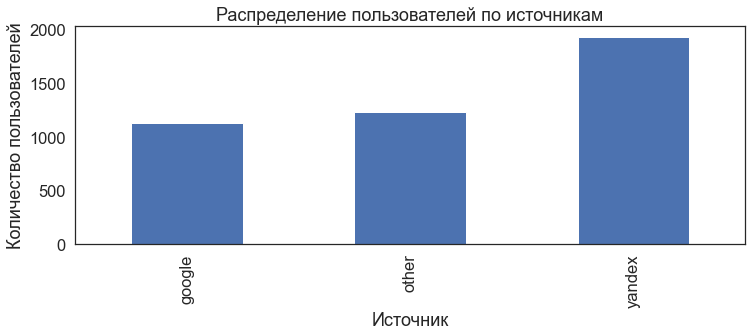

In [14]:
(
    data
    .groupby('source')
    .agg({'user_id':'nunique'})
    .plot.bar(legend=None, figsize=(12,4))
)

plt.title('Распределение пользователей по источникам')
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')

plt.show();

Группы не сильно отличаются.

Проверим, что происходит в кадом типе события.

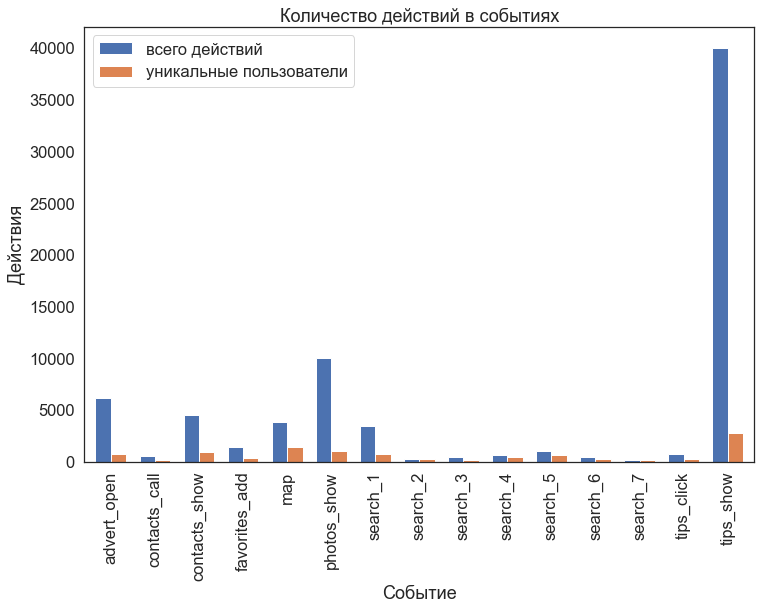

In [15]:
data_event_count = (
    data
    .groupby('event_name')
    .agg({'user_id':'count'})
    .reset_index()
    .rename(columns={'user_id':'всего действий'})
)

data_event_nunique = (
    data
    .groupby('event_name')
    .agg({'user_id':'nunique'})
    .reset_index()
    .rename(columns={'user_id':'уникальные пользователи'})
)

data_event = data_event_count.merge(data_event_nunique, on='event_name')

data_event.plot.bar(x='event_name', width=0.7, figsize=(12, 8))

plt.title('Количество действий в событиях')
plt.xlabel('Событие')
plt.ylabel('Действия')

plt.show();

Это не похоже на странные выбросы, скорее логичная картина: событий в каждом действии меньше, чем уникальных пользователей, его совершивших. Но есть несколько наблюдений:

- Первое, что бросается в глаза- это очень большое количество просмотров рекомендованных объявлений.
- Так же, небольшое количество поисков объявлений.
- Довольно большое количество просмотренных фотографий.

Уже можно сделать некоторые выводы:

Большинство пользователей приложения любит заходить и листать рекомендации, а не искать вещи самостоятельно, при этом, часто просматривая фотографии вещей. 

Проверим, сколько сессий у каждого пользователя.

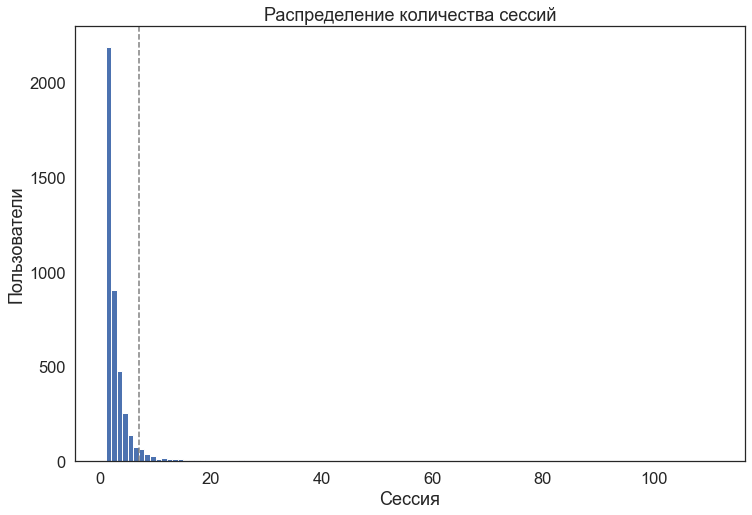

Сессий у 95% пользователей: 7.0


In [16]:
sessions = (
    data
    .pivot_table(index='user_id',
                values='session',
                aggfunc='max')
    .reset_index()
)

sessions.plot.hist(
    by='session', 
    bins=110, 
    legend=None, 
    figsize=(12, 8)
)

plt.axvline(x=sessions['session'].quantile(0.95),
            color='gray',
            linestyle='--')

plt.title('Распределение количества сессий')
plt.xlabel('Сессия')
plt.ylabel('Пользователи')

plt.show();

print('Сессий у 95% пользователей: {}'.format(sessions['session'].quantile(0.95)))

Распределение нормальное: плавное снижение количества сессий. Не так много юзеров заходили стабильно часто в приложение за расчетный период, но большинство, в среднем, больше одного раза в день. Отсеим пользователей, у которых больше 40 сессий, их явное меньшинство.

Проверим также и количество событий у каждого пользователя. 

,user_id,event_name
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8


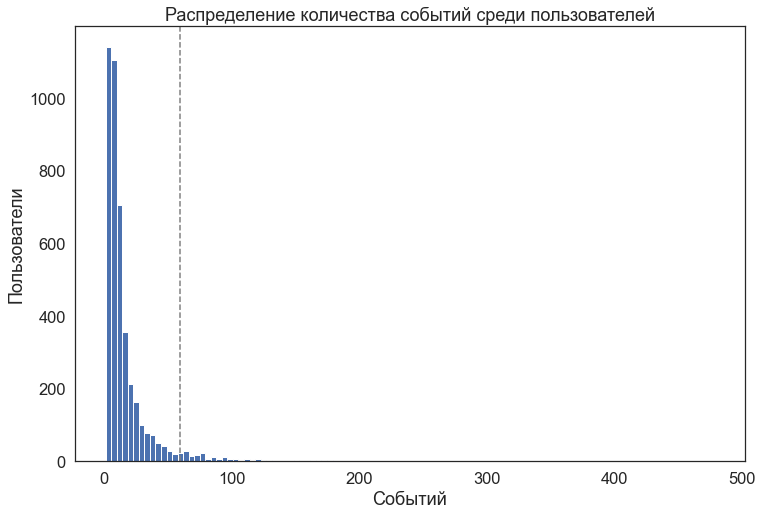

Событий у 95% пользователей: 59.0


In [17]:
events = (
    data
    .groupby('user_id')
    .agg({'event_name':'count'})
    .reset_index()
    .sort_values(by='user_id')
)

display(events.head())

events.plot.hist(
    by='user_id',
    bins=110,
    legend=None,
    figsize=(12, 8)
)

plt.axvline(x=events['event_name'].quantile(0.95),
            color='gray',
            linestyle='--')

plt.title('Распределение количества событий среди пользователей')
plt.xlabel('Событий')
plt.ylabel('Пользователи')

plt.show();

print('Событий у 95% пользователей: {}'.format(events['event_name'].quantile(0.95)))

Картина похожая. Оставим юзеров с 80 событиями и меньше, их ходя бы видно на графике.

Взглянем еще раз на распределение этих двух величин, чтобы ничего не упустить. На этот раз под другим углом- с использованием точечного графика.

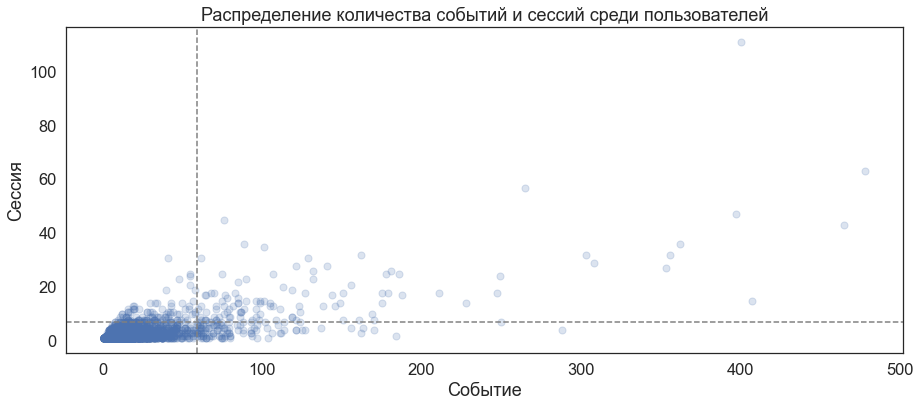

In [18]:
session_event = (
    data
    .groupby('user_id')
    .agg({'event_name':'count', 'session':'max'})
    .reset_index()   
)

session_event.plot.scatter(x='event_name', y='session', c='#4d73b0', s=50, alpha=0.2, figsize=(15, 6))

plt.axhline(y=sessions['session'].quantile(0.95),
            color='gray',
            linestyle='--')
plt.axvline(x=events['event_name'].quantile(0.95),
            color='gray',
            linestyle='--')

plt.title('Распределение количества событий и сессий среди пользователей')
plt.xlabel('Событие')
plt.ylabel('Сессия')

plt.show();

Похоже, что предыдущие выводы подтвердились, у абсолютного большинства пользователей приложения меньше 40 сессий и меньше 80 событий в расчетный период.

In [19]:
session_event = session_event[np.logical_and(
    session_event['event_name'] <= events['event_name'].quantile(0.95),
    session_event['session'] <= sessions['session'].quantile(0.95)
)]

print('Пользователей после фильтрации: {}'.format(len(session_event['user_id'])))

Пользователей после фильтрации: 3995


Избавившись от выделяющихся пользователей, мы потеряли всего 298 юзеров в таблице, это меньше 7% общего количества. Зато теперь значения наиболее близки друг к другу.

In [20]:
data_filtered = data[data['user_id'].isin(session_event['user_id'])]

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47640 entries, 0 to 74194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  47640 non-null  datetime64[ns]
 1   event_name  47640 non-null  object        
 2   user_id     47640 non-null  object        
 3   source      47640 non-null  object        
 4   session     47640 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 2.0+ MB


Выбывшие пользователи генерировали треть событий. Возможно, они заслуживают отдельного анализа. Но их слишком мало для достоверных расчетов, следует взять больший промежуток времени.

Проверим последние значения: количество событий на сессию.

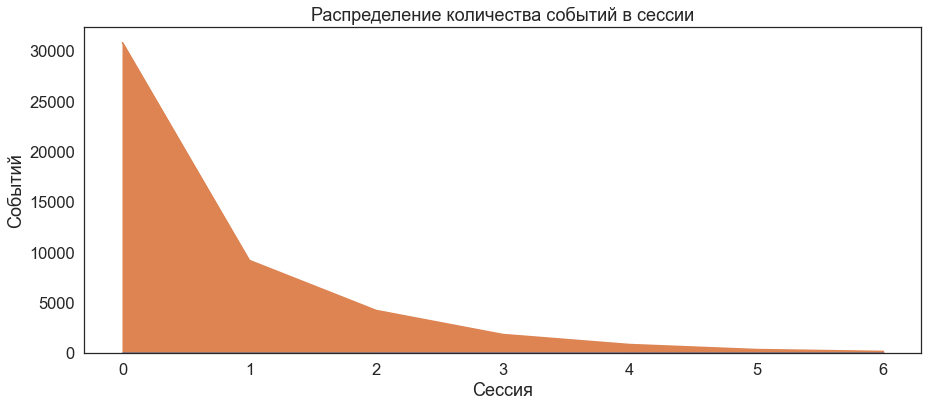

In [21]:
(
    data_filtered
    .groupby('session')
    .agg({'event_name':'count'})
    .reset_index()
    .sort_values(by='session')
    .plot.area(legend=None, figsize=(15, 6))
)

plt.title('Распределение количества событий в сессии')
plt.xlabel('Сессия')
plt.ylabel('Событий')

plt.show();

Всё довольно предсказуемо, значимых выбросов нет.

### Предварительные выводы:

- Большиство пользователей заходит в приложение раз в несколько дней (до 7 раз за 28  дней).
- Чаще всего юзеры совершают небольшое количество действий за расчетный период (до 59).
- В сессию совершается 1-3 действие, реже до 6.
- Самое популярное действие- просмотр рекомендаций аболютный лидер по количеству действий) и фотографий (вчетверо меньше, чем просмотр рекомендаций).
- Пользователи не очень любят искать вещи самостоятельно (в 10 раз реже, чем просмотр рекомендаций).

# Группировка пользователей

### Выделение важных признаков
Проверим распределение действий.

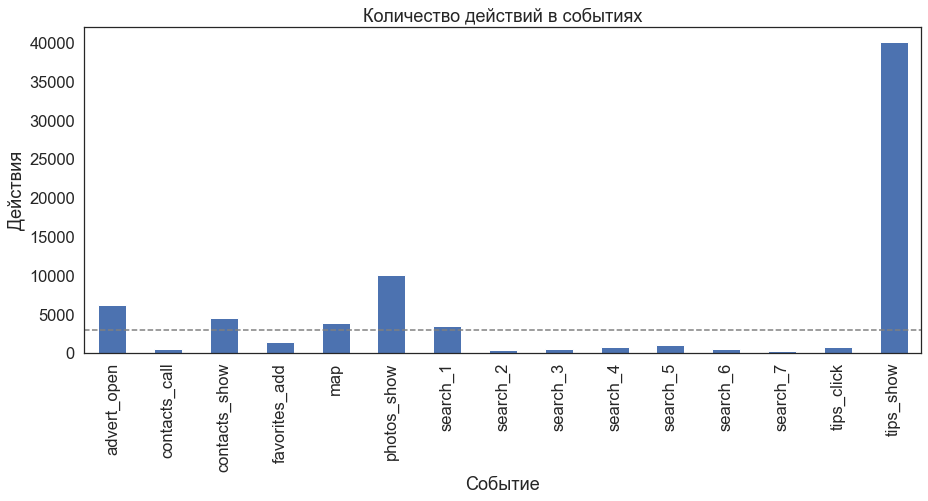

In [22]:
data_event_count.plot.bar(x='event_name', legend=None, figsize=(15, 6))

event_limit=3000

plt.axhline(y=event_limit,
            color='gray',
            linestyle='--')

plt.title('Количество действий в событиях')
plt.xlabel('Событие')
plt.ylabel('Действия')

plt.show();

Можно заметить несколько выделяющихся действий. Возьмем границу в 3000 действий, остальные сильно ниже.

In [23]:
features = data_event_count[data_event['всего действий']>event_limit]['event_name'].tolist()

data_features = data_filtered[data_filtered['event_name'].isin(features)]

print(data_features['event_name'].value_counts())

tips_show        25587
photos_show      6764 
advert_open      3221 
map              2682 
search_1         2594 
contacts_show    2486 
Name: event_name, dtype: int64


У нас осталось 6 важных действий, совершаемыхчаще всего: 

- `tips_show` — пользователь увидел рекомендованные объявления
- `photos_show` — просмотр фотографий в объявлении
- `advert_open` — открытие карточки объявления
- `search_1` — поиск по сайту
- `map` — пользователь открыл карту размещенных объявлений
- `contacts_show` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления

### Аргументация методики сегментации

У нас есть 6 важных действий и 3 канала привлечения пользователей. Можно было бы оставить только последнее и мегментировать пользователей только по ним. Но интересно посмотреть, какие еще взаимосвязи можно обнаружить вреди всех этих опций. Мне кажется, что метод K-Means хорошо справится с этой задачей.

### Кластеризация пользователей по выделенным признакам

Подготовим таблицу для кластеризации. Вместо общего количества действий на пользователя, можно сделать таблицу со средним количеством одинаковых действий для каждого id.

In [24]:
data_cluster = (
    data_features
    .drop(['event_time'], axis=1)
)

data_cluster = pd.get_dummies(data=data_cluster, columns=['event_name', 'source'])

data_cluster = (
    data_cluster
    .groupby('user_id')
    .agg('mean')
    .reset_index()
)

display(data_cluster.head())

,user_id,session,event_name_advert_open,event_name_contacts_show,event_name_map,event_name_photos_show,event_name_search_1,event_name_tips_show,source_google,source_other,source_yandex
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.600000,0.0,0.0,0.171429,0.0,0.0,0.828571,0.0,1.0,0.0
1,00463033-5717-4bf1-91b4-09183923b9df,1.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,1.0
2,00551e79-152e-4441-9cf7-565d7eb04090,2.000000,0.0,0.6,0.000000,0.2,0.2,0.000000,0.0,0.0,1.0
3,00554293-7e00-4122-b898-4e892c4a7c53,1.333333,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,1.0
4,005fbea5-2678-406f-88a6-fbe9787e2268,1.000000,0.0,0.6,0.000000,0.0,0.0,0.400000,0.0,0.0,1.0


Выведем матрицу корелляций, чтобы увидеть линейные взаимосвязи. Высокая корелляция не означает связь между признаками, как и ее отсутствие не означает отсутсвие их влияния друг на друга. Эта матрица позволят сделать предположения о связи двух признаком друг с другом.

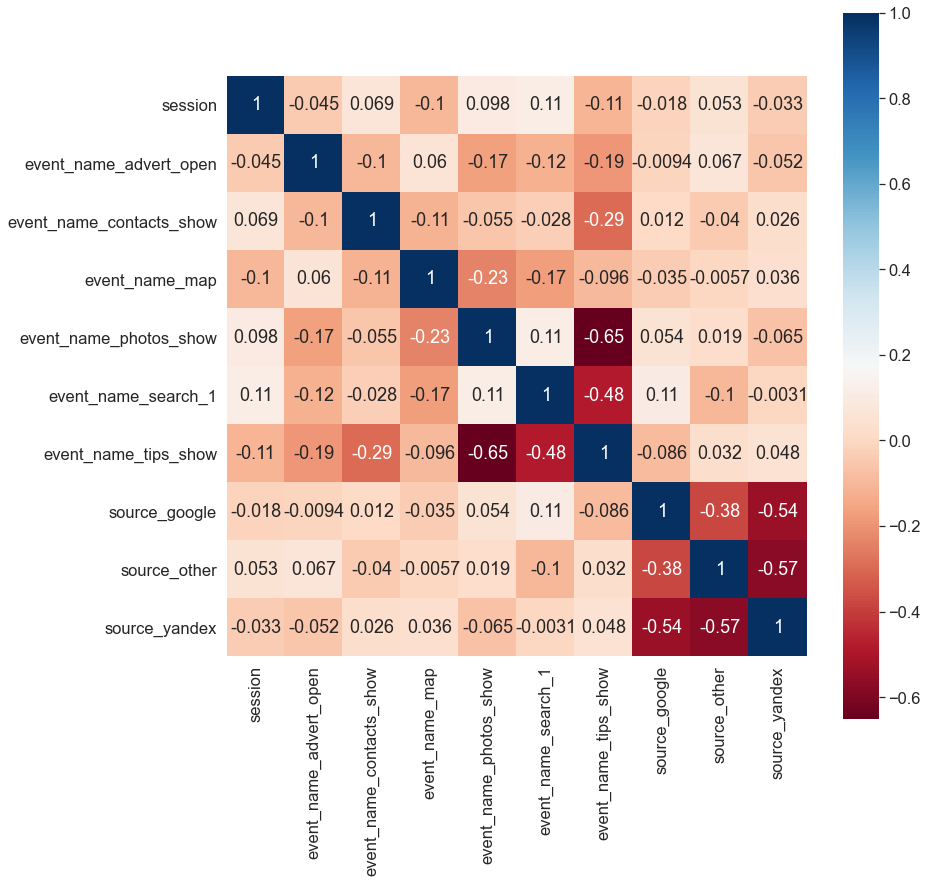

In [25]:
cm = data_cluster.corr()

#визуализируем матрицу
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(cm, annot=True, square=True, cmap="RdBu")
plt.show()

Существует умеренная корелляция между просмотром рекомендаций и просмотром фотографий. Также, между просмотром рекомендаций и поиском. В общем, наблюдается умеренная корелляция и между каналами привлечения, это и понятно: если пришел по одному, то не пришел по другим.
Слабая корелляция наблюдается между многими признаками. Чтобы не утонуть в преположениях, отдадим эти данные на анализ машине.

### Иерархическая кластеризация
Она позволит визуально оценить связи между признаками в небольшой выборке (3000 пользователей), чтобы использовать эти данные для более точного метода K-Means.

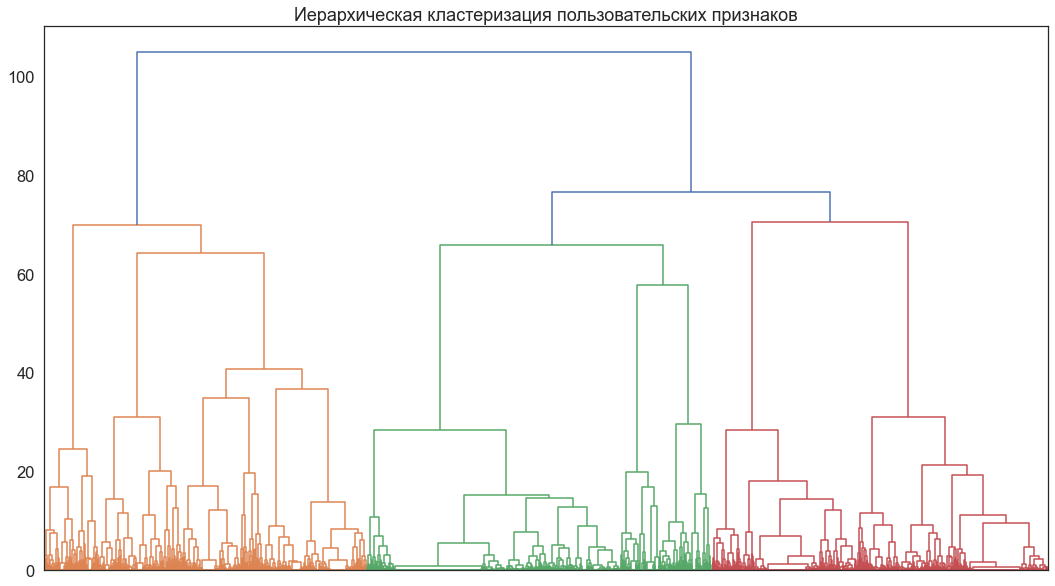

In [26]:
#создаем иерархическую кластеризацию
data_cluster_dendro = data_cluster.drop(columns='user_id').sample(3000)

scaler = StandardScaler()
data_cluster_dendro_st = scaler.fit_transform(data_cluster_dendro)
linked = linkage(data_cluster_dendro_st, method = 'ward')

#визуализируем ее
plt.figure(figsize=(18, 10)) 
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Иерархическая кластеризация пользовательских признаков')
plt.show();

Иерархическая кластеризация предлагает 3 кластера, но я считаю, что это маловато, ведь 3 кластера у нас всегда есть (каналы привлечения), добавим 4 кластер. Его можно различить на матрице корелляций: это просмотр фото и поиск, проверим, найдет ли между ними связь алгоритм.

### Метод K-Means

In [27]:
data_kmeans = data_cluster.drop(columns='user_id')

scaler = StandardScaler()
data_st = scaler.fit_transform(data_kmeans)
#делим выборку на кластеры
km = KMeans(n_clusters=4, random_state=22)
clusters = km.fit_predict(data_st)

data_kmeans['cluster'] = clusters

#размер каждого кластера
cluster_count = (
    data_kmeans
    .pivot_table(
        index='cluster',
        values='session',
        aggfunc='count')
    .reset_index()
    .rename(columns={'session':'cluster_size'})
)

#таблица с переменными кластеров
cluster_features = (
    data_kmeans
    .groupby(['cluster'])
    .mean()
    .reset_index()
    .T
    .style
    .background_gradient(cmap='coolwarm', axis=1)
    .set_precision(3)
)

display(cluster_count)
display(cluster_features)

,cluster,cluster_size
0,0,1056
1,1,1338
2,2,860
3,3,691


,0,1,2,3
cluster,0.000,1.000,2.000,3.000
session,1.604,1.355,1.436,1.336
event_name_advert_open,0.006,0.066,0.105,0.088
event_name_contacts_show,0.052,0.079,0.062,0.083
event_name_map,0.000,0.109,0.097,0.098
event_name_photos_show,0.630,0.005,0.006,0.012
event_name_search_1,0.312,0.002,0.001,0.007
event_name_tips_show,0.000,0.739,0.728,0.712
source_google,0.331,0.000,0.000,1.000
source_other,0.254,0.000,1.000,0.000


Кластеры получились с небольшим разбросом и довольно большие (от 17% до 33% от общего числа). 3 кластера по каналу привлечения еще один с просмотром фото и поиском, как и предполагалось. Взглянем поближе.

### Обзор групп

In [28]:
data_cluster['cluster'] = data_kmeans['cluster']
data_features = data_features.merge(data_cluster[['user_id','cluster']], on='user_id')

In [29]:
display(
    data_features
    .groupby(['cluster', 'event_name', 'source'])
    .agg({'user_id':'nunique', 'session':'count'})
    .reset_index()
    .rename(columns={'user_id':'users', 'session':'sessions'})
    .style
    .background_gradient(cmap='coolwarm', axis=0)
)

,cluster,event_name,source,users,sessions
0,0,advert_open,google,10,20
1,0,advert_open,other,5,6
2,0,advert_open,yandex,20,59
3,0,contacts_show,google,82,159
4,0,contacts_show,other,50,85
5,0,contacts_show,yandex,112,240
6,0,photos_show,google,307,2372
7,0,photos_show,other,248,1728
8,0,photos_show,yandex,380,2480
9,0,search_1,google,259,972


- Кластер `0`: больше всего просмотра фотографий товаров и использование поиска, почти нет остальных действий. Среднее количество сессий тут самое большое. Пользователи пришли по разным каналам, пропорционально общему количеству на канал. Назовем этот кластер `photos`.

- Кластер `1`: пользователи из канала привлечения `yandex`. Так кластер и назовём. Среднее количество сессий. Низкое количество открытий карточки товара, но самое большое количество открытий карты. 

- Кластер `2`: из канала `other`. Похож на кластер Яндекса, но самое большое количество открытий карточек товаров и самое низкое количество просмотров контактов.

- Кластер `3`: пришедшие через `google`. Тоже похож на Яндекс, но с отличиями: самое низкое количество сессий на пользователя, самое большое количество открытых  контактов.

У кластеров по каналу привлечения стабильно одинаковое количество просмотренныхрекомендаций, а в кластере `photos` наоборот, полное отсутсвие, как, в принципе и любых  других действий, кроме фото и карты.

In [30]:
cluster_names = ['photos', 'yandex', 'other', 'google']
data_features['cluster'] = data_features['cluster'].replace([0,1,2,3], cluster_names)

In [31]:
data_features.sample(5)

,event_time,event_name,user_id,source,session,cluster
38045,2019-10-30 13:15:56.814922,tips_show,ca96ac2e-99ca-4bbc-8278-bae5c62869eb,other,1,other
36776,2019-10-29 14:31:20.124287,photos_show,8a9c14ef-c1fe-4b0b-adb4-2bc908b96114,yandex,1,photos
8672,2019-10-12 11:53:49.517132,advert_open,a9026c03-ee13-4b7d-a17a-27c22f0a1927,yandex,2,yandex
15748,2019-10-16 00:10:11.283253,tips_show,ff82c7c7-16d6-44b1-833b-a217747b0b02,yandex,1,yandex
34845,2019-10-28 22:10:07.412936,photos_show,710050ed-a904-41dd-9637-ef2de68e5659,google,2,photos


Теперь каждый пользователь имеет свой уникальный кластер.

### Предварительные выводы по кластеризации:

Разделение по кластером получилось интересным и показательным. Присутствует разделение по каналам привлечения, причем, кластеры по каналам похожи между собой, но с небольшими перевесами по тому или ониу действию. А также есть один кластер, в котором почти все действия-это просмотр фото и поиск.

- Кластер `photos` содержит в себе пользователей, которые занимаются исключительно простотром фотокарточек товара и поиском в приложении. Это примечательно, ведь остальные кластеры не содержат в себе этих  действий. Также, у этого кластера самое большое среднее количество сессий на человека.

- Кластер `yandex` для пользователей, пришедших из Яндекс. Чаще всех пользуются картой, но редко открывают карточки товара.

- Кластер `other` для привлеченных по другим каналам. Самое большое количество открытий карточек товаров и самое низкое количество просмотров контактов.

- Кластер `google` состоит из пользователей из Гугл. Самое низкое количество сессий на пользователя, самое большое количество открытых контактов.

## Пользователи какой группы склонны возвращаться?
### Retention rate

### Определить горизонт анализа

In [32]:
print(data_features['event_time'].max() - data_features['event_time'].min())

27 days 23:56:56.610468


Данные в таблице за 28 дней. Посмотрим, как много "прожили" пользователи.

In [33]:
rr_data = (
    data_features
    .groupby(['user_id', 'cluster', 'session'])
    .agg(session_start=('event_time', np.min), session_end=('event_time', np.max))
    .reset_index()
)

rr_data['session_start']=rr_data['session_start'].dt.date
rr_data['session_end']=rr_data['session_end'].dt.date

h = rr_data.groupby(['user_id']).agg(first_ts=('session_start', np.min))
rr_data = rr_data.merge(h, on='user_id')

rr_data['lifetime'] = (((rr_data['session_start'] - rr_data['first_ts']).dt.days) / 7).round().astype('int')


display(rr_data.head(5))

horizont_data = (
    rr_data
    .groupby('cluster')
    .agg({'lifetime':'max'})
    .reset_index()
)

print('Минимальный горизонт: {} недель'.format(horizont_data['lifetime'].min()))

,user_id,cluster,session,session_start,session_end,first_ts,lifetime
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07,2019-10-07,2019-10-07,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,2019-10-09,2019-10-09,2019-10-07,0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,3,2019-10-21,2019-10-21,2019-10-07,2
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,4,2019-10-22,2019-10-22,2019-10-07,2
4,00463033-5717-4bf1-91b4-09183923b9df,photos,1,2019-11-01,2019-11-01,2019-11-01,0


Минимальный горизонт: 4 недель


Ни один пользователь не пользовался приложением с первого до последнего дня анализа.

Подготовим функция для расчет удержания.

In [34]:
def get_retention(
    rr_data,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = rr_data.query('first_ts <= @last_suitable_acquisition_date')

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[['cohort_size'] + list(range(horizon_days))]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

### Посчитать retention rate

Воспользуемся нашей функцией.

In [35]:
retention_raw, retention = get_retention(
    rr_data, 
    data_features['event_time'].max().date(), 
    4, 
    dimensions=['cluster']
)

retention

,cohort_size,0,1,2,3
cluster,,,,,
google,633,1.0,0.096367,0.042654,0.011058
other,790,1.0,0.117722,0.054430,0.017722
photos,963,1.0,0.224299,0.077882,0.029076
yandex,1224,1.0,0.131536,0.049837,0.018791


Таблица готова, надо ее визуализировать.

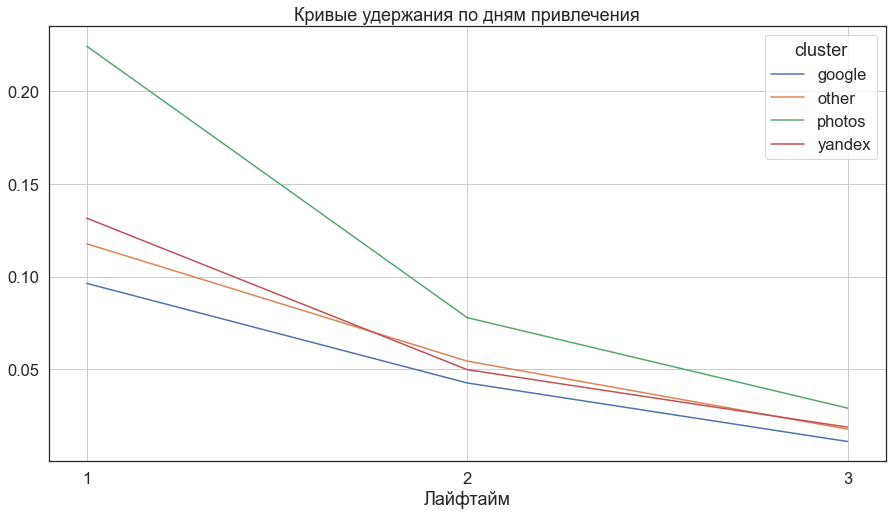

In [36]:
report = retention.drop(columns = ['cohort_size']).T
report = retention.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,
    xticks=list(report.columns.values), 
    figsize=(15, 8),
)
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания по дням привлечения')
plt.show()

### Наблюдения
- Во всех кластерах резкое падение удержание к концу второй недели. 
- У кластера `photos` удержание выше других, даже к концу времени анализа.
- У кластеров по каналу привлечения схожие кривые удержания.
- Кластер `google` показывает самое низкое удержание.

## Время, проведённое в приложении

### Определить время сессии
Посчитаем длдительность каждой сессии и добавим данные в таблицу.

In [37]:
time_data = (
    data_features
    .groupby(['user_id', 'cluster', 'session'])
    .agg(session_start=('event_time', np.min), session_end=('event_time', np.max))
    .reset_index()
)

time_data['session_time'] = time_data['session_end'] - time_data['session_start']
time_data['session_day'] = time_data['session_start'].dt.date
time_data['session_time'] = time_data['session_time'].dt.total_seconds()

time_data.sample(5)

,user_id,cluster,session,session_start,session_end,session_time,session_day
477,1022b793-7ae7-4ac0-8c52-54ffed1c8182,photos,2,2019-10-20 00:52:13.231362,2019-10-20 01:21:18.917875,1745.686513,2019-10-20
7103,f553a25f-67a7-4c5b-ab08-9f56a388cdb4,other,2,2019-10-17 11:38:26.471067,2019-10-17 11:38:26.765177,0.294110,2019-10-17
5249,b6cb89f2-0935-4e28-be32-50e439b8487f,other,1,2019-10-18 13:29:18.387592,2019-10-18 13:36:16.882015,418.494423,2019-10-18
2340,5260a14a-f2b9-43be-8bec-cab1e3c85f57,other,3,2019-10-20 17:14:16.496934,2019-10-20 17:34:18.723867,1202.226933,2019-10-20
2358,52dd831d-c505-44fe-87ef-18e4ad944f93,other,2,2019-10-11 22:46:09.603975,2019-10-11 22:46:09.603975,0.000000,2019-10-11


### Посчитать время в приложении для групп

Подготовим данные.

In [38]:
mean_duration_data = (
    time_data
    .groupby(['session_day', 'cluster'])
    .agg(total_duration=('session_time', 'mean'))
    .reset_index()
)

values = mean_duration_data.groupby('cluster')['total_duration'].agg('sum')

print(values)

cluster
google    19877.539282
other     16776.046687
photos    11852.608423
yandex    20215.506510
Name: total_duration, dtype: float64


Выведем среднее время по кластерам за все время исследования.

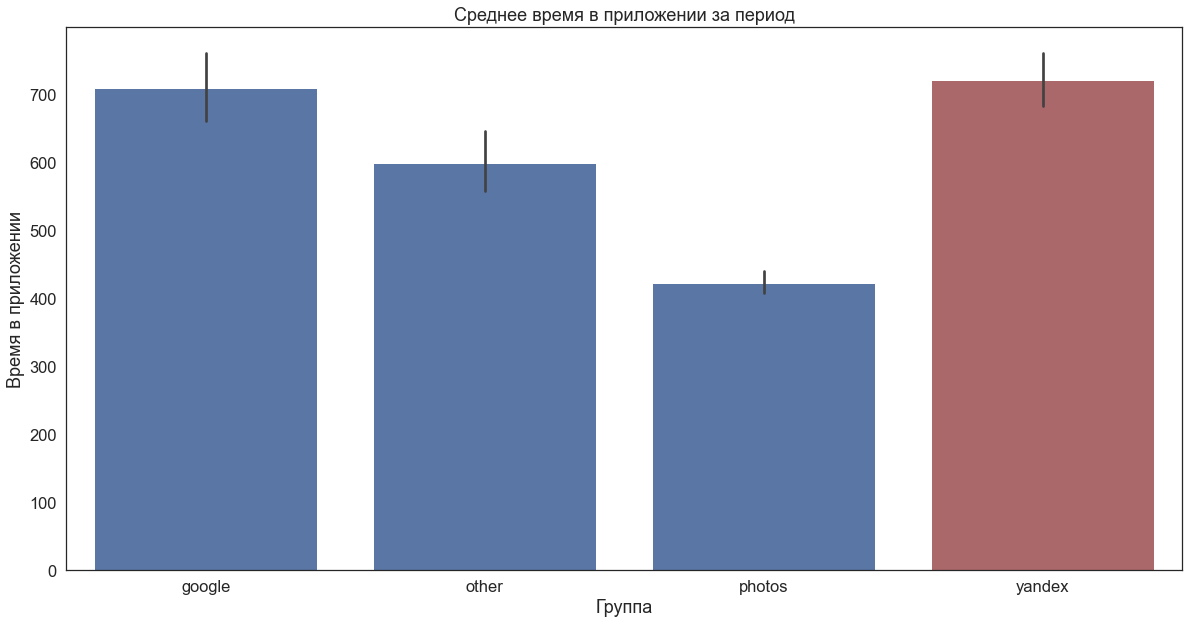

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))

clrs = ['#4d73b0' if (x<max(values)) else '#b55d60' for x in values]

sns.barplot(
    x='cluster',
    y='total_duration',
    data=mean_duration_data,
    palette=clrs
)

plt.title('Среднее время в приложении за период')
plt.xlabel('Группа')
plt.ylabel('Время в приложении');

Кластер Яндекс показывает самое большоевремя, проведенное в приложении. Недалеко и Гугл. А вот кластер Фото ниже почти вдвое.

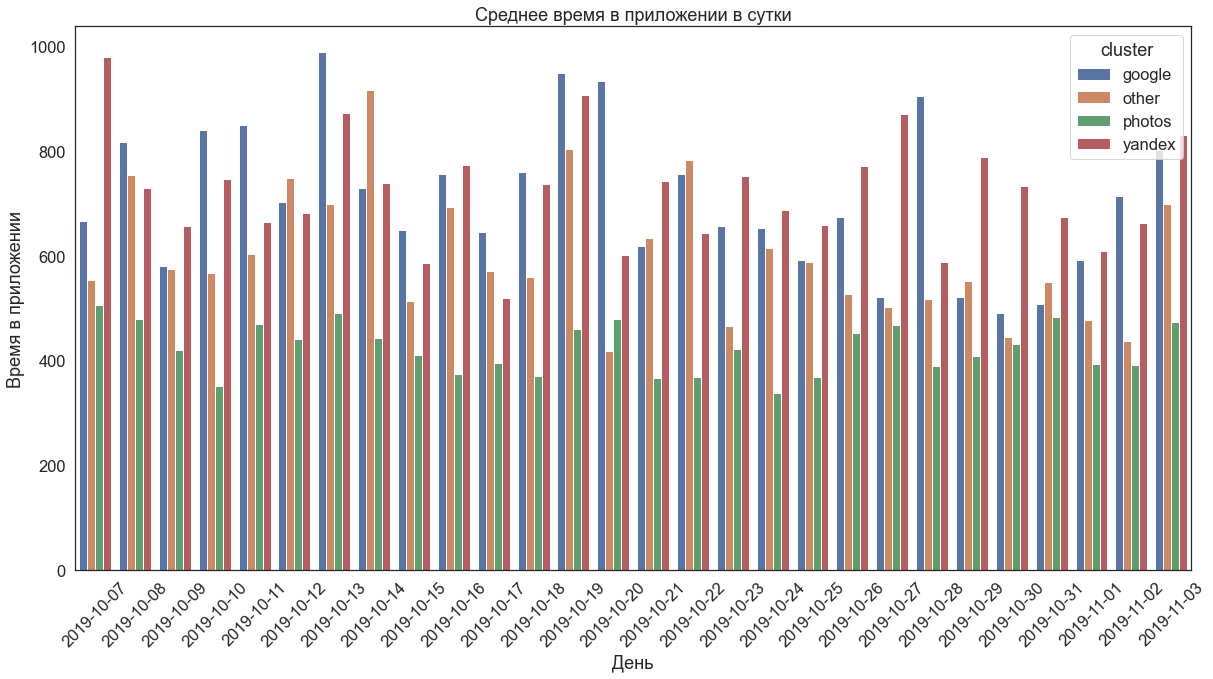

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(
    x='session_day',
    y='total_duration',
    hue='cluster',
    data = mean_duration_data
)

plt.xticks(rotation=45)
plt.title('Среднее время в приложении в сутки')
plt.xlabel('День')
plt.ylabel('Время в приложении');

Время в приложении несильно падает к концу анализа, но не существенно. График выглядит немного цикличным, посмотрим по кластерам.

In [41]:
session_day = (
    time_data
    .groupby(['cluster', 'session_day'])
    .agg(total_duration=('session_time', 'sum'))
    .reset_index()
)

session_day.head()

,cluster,session_day,total_duration
0,google,2019-10-07,32001.240814
1,google,2019-10-08,33483.327664
2,google,2019-10-09,20886.982808
3,google,2019-10-10,33657.435286
4,google,2019-10-11,25496.709005


Построим график времени в приложении за день для каждого кластера.

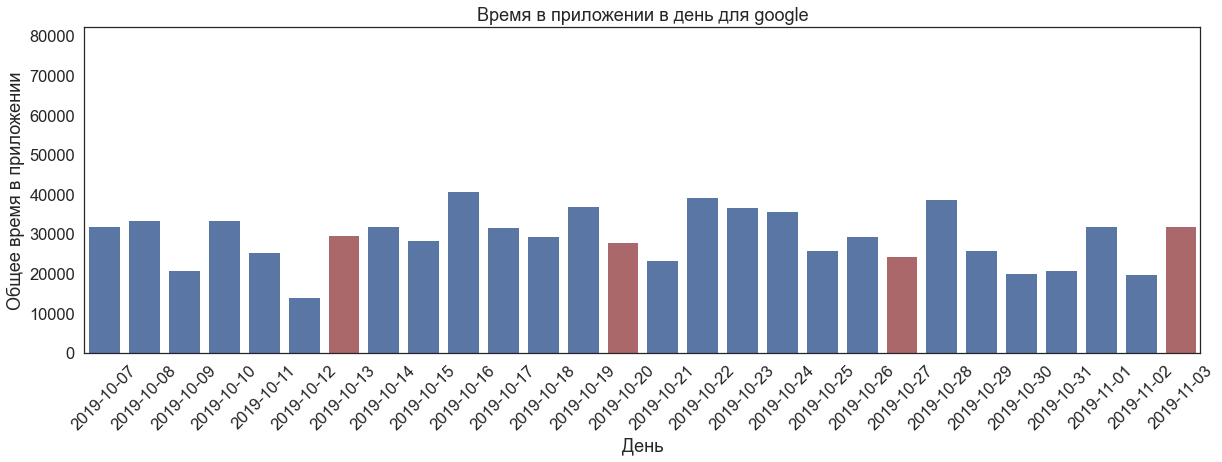

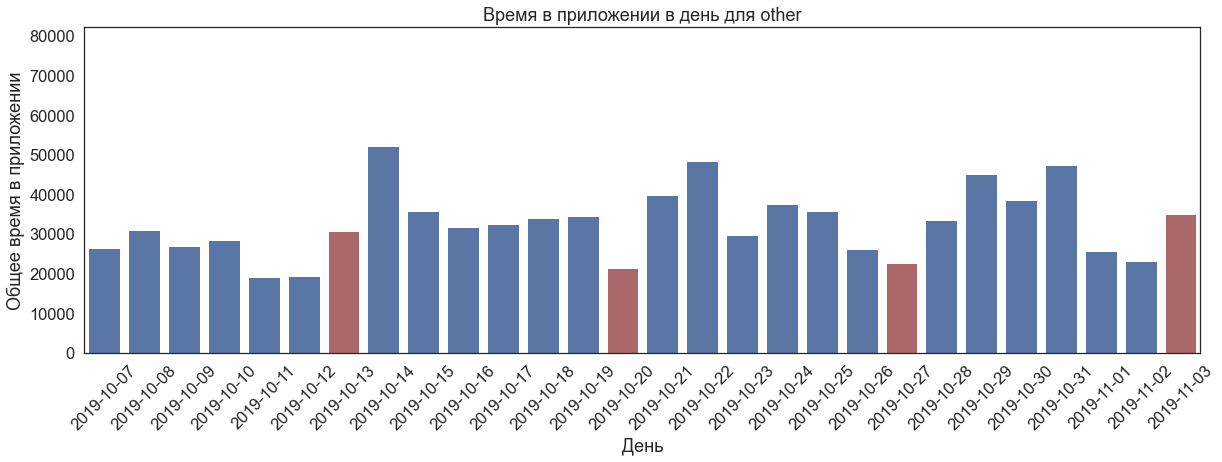

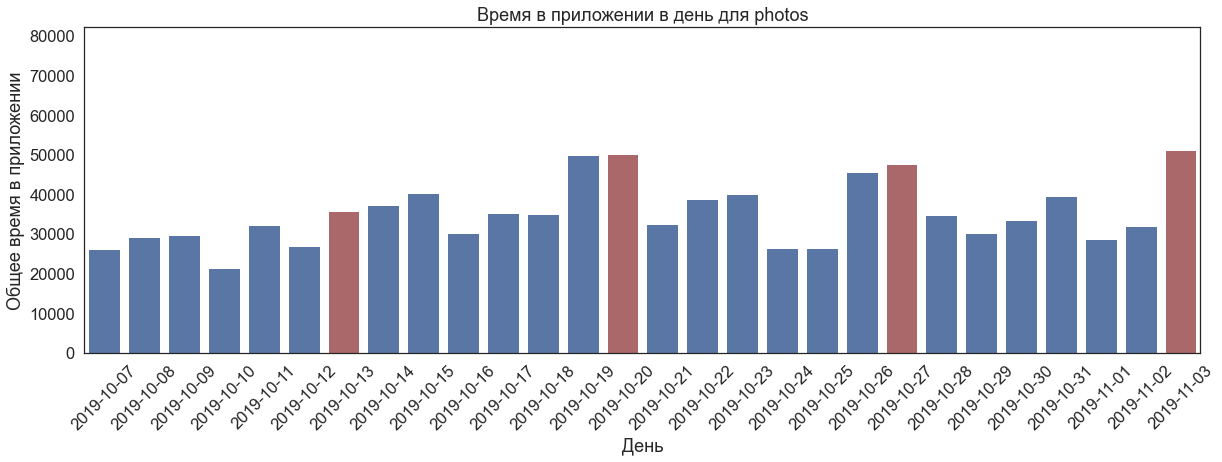

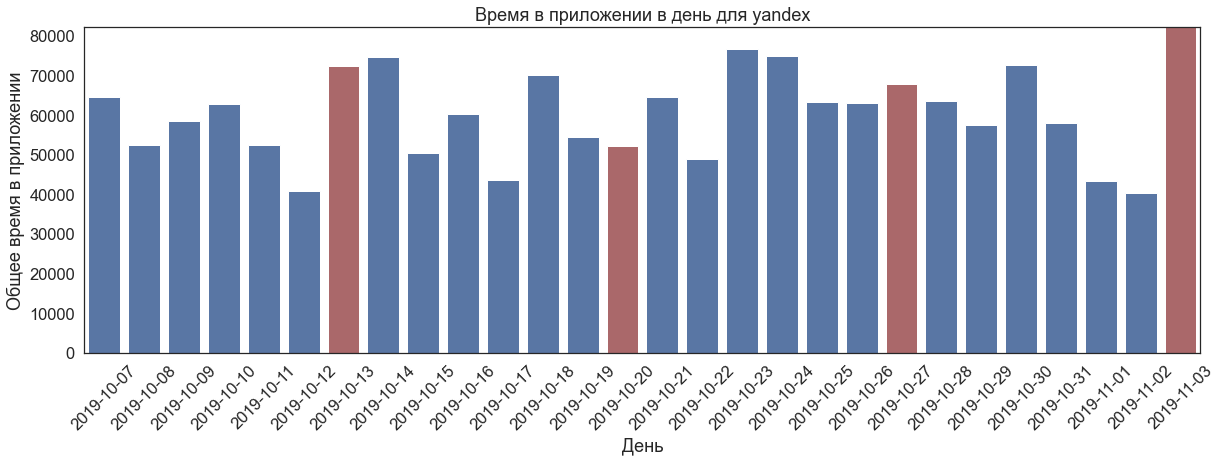

In [42]:
weekdays = pd.to_datetime(session_day['session_day']).dt.weekday 
clrs = ['#b55d60' if (x==6) else '#4d73b0' for x in weekdays]

for col in session_day['cluster'].unique().tolist():
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.barplot(
        data=session_day[session_day['cluster']==col],
        x='session_day',
        y='total_duration',
        palette=clrs
    )

    plt.ylim(0, session_day['total_duration'].max()+100)
    plt.xticks(rotation=45)
    plt.title(f'Время в приложении в день для {col}')
    plt.xlabel('День')
    plt.ylabel('Общее время в приложении')
    plt.show();

### Наблюдения

- Для кластера `google` время в приложении меняется сильно, есть всплески в середине недели, есть по выходным. Но чаще всего их видно в начале недели.

- График для `other` показывает наибольшую активность в начале недели и низкую по выходным.

- На графике `photos` стабильно активность по выходным выше, причем подъем довольно плавный каждую неделю.

- График для `yandex` показывает картину, больше похожую на случайную, зато стабильно высокая активность.

## Частота действий
Проверим группы по частоте действий.

### Выявить нужные действия

Создадим таблицу с количеством действий по пользователям и кластерам.

In [43]:
data_frequency = pd.get_dummies(data=data_features, columns=['event_name'], prefix='', prefix_sep='')

event_list = list(data_features['event_name'].unique())

d = {'count':'event_time', 'sum' : event_list}

out = {}
for k, v in d.items():
    if isinstance(v, list):
        for x in v:
            out[x] = k
    else:
        out[v] = k

data_frequency = (
    data_frequency
    .drop(columns=['source'])
    .groupby(['user_id', 'cluster', 'session'])
    .agg(out)
    .reset_index()
    .rename(columns={'event_time':'events_total'})
)

data_frequency.head()

,user_id,cluster,session,events_total,advert_open,tips_show,map,photos_show,search_1,contacts_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,9,0,9,0,0,0,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,4,0,2,2,0,0,0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,3,14,0,12,2,0,0,0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,4,8,0,6,2,0,0,0
4,00463033-5717-4bf1-91b4-09183923b9df,photos,1,10,0,0,0,10,0,0


Посмотрим на средние значения всех действий по кластерам.

In [44]:
display(
    data_frequency
    .drop(columns='user_id')
    .groupby('cluster')
    .agg({'mean'})
    .reset_index()
    .style.background_gradient(cmap='coolwarm', axis=0)
    .set_precision(2)
)

,cluster,session,events_total,advert_open,tips_show,map,photos_show,search_1,contacts_show
,,mean,mean,mean,mean,mean,mean,mean,mean
0,google,1.74,7.17,0.67,5.38,0.59,0.07,0.03,0.44
1,other,1.90,5.98,0.74,4.45,0.44,0.03,0.01,0.32
2,photos,2.10,4.14,0.04,0.00,0.00,2.82,1.08,0.21
3,yandex,1.80,6.77,0.51,5.24,0.56,0.03,0.01,0.42


В среднем:
- Пользователи из `google` совершают 7.17 действий, больше всех. Каждый смотрит больше 5 рекомендации, две трети открывают карточку объявления, каждый второй смотрит карту. Почти половина открывает контакты, больше всех.

- Пользователи из `other` совершают 5.98 действий. Три четверти пользователей открывают карточку объявления. Каждый смотрит больше 4 рекомендации. Просматривает контакты каждый третий.

- Пользователи из `photos` совершают 4.14 действия, меньше всех. Каждый смотрит почти 3 фотографии, каждый пользуется поиском, а смотрит контакты только каждый пятый, меньше всех.

- Пользователи из `yandex` совершают 6.77 действий. Каждый смотрит больше 5 рекомендации, половина открывают карточку объявления, каждый второй смотрит карту. Меньше половина открывает контакты.

### Посчитать действия в приложении для групп
Посмотрим, как много и каких действий в сессию происходит в кластерах.

Подготовим данные.

In [45]:
cluster_frequency = (data_frequency
        .drop(columns='user_id')
        .groupby(['cluster', 'session'])
        .agg({'sum'})
        .reset_index()
)

cluster_frequency.columns = cluster_frequency.columns.droplevel(1)

cluster_frequency.head()

,cluster,session,events_total,advert_open,tips_show,map,photos_show,search_1,contacts_show
0,google,1,5645,499.0,4234.0,517.0,48.0,25.0,322.0
1,google,2,1672,220.0,1226.0,90.0,19.0,4.0,113.0
2,google,3,721,28.0,566.0,63.0,5.0,1.0,58.0
3,google,4,270,26.0,213.0,18.0,3.0,0.0,10.0
4,google,5,65,3.0,52.0,2.0,0.0,0.0,8.0


In [46]:
event_session_data = (
    data_features
    .groupby(['cluster', 'session', 'event_name'])
    .agg({'event_time':'count'})
    .reset_index()
    .rename(columns={'event_time':'events'})
)

event_session_data.head()

,cluster,session,event_name,events
0,google,1,advert_open,499
1,google,1,contacts_show,322
2,google,1,map,517
3,google,1,photos_show,48
4,google,1,search_1,25


Построим график частоты действий за сессию.

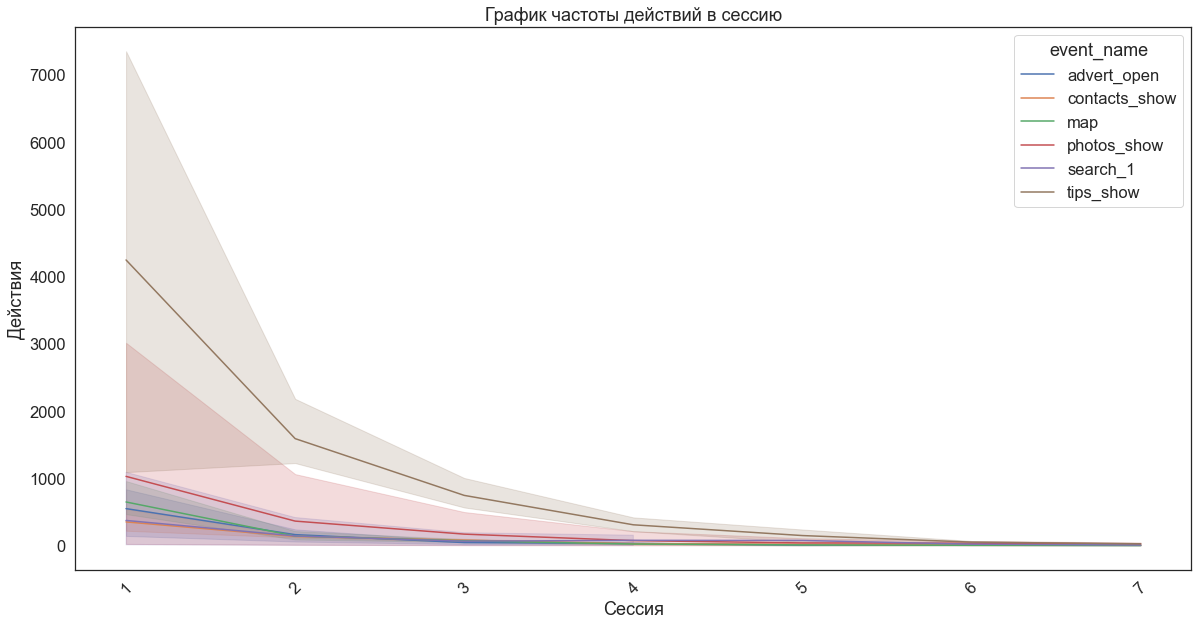

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(
    data=event_session_data,
    x='session',
    y='events',
    hue='event_name'
)

plt.xticks(rotation=45)
plt.title('График частоты действий в сессию')
plt.xlabel('Сессия')
plt.ylabel('Действия')
plt.show();

Ожидаемо, снижается. Разобьем по кластерам, увеличим масштаб.

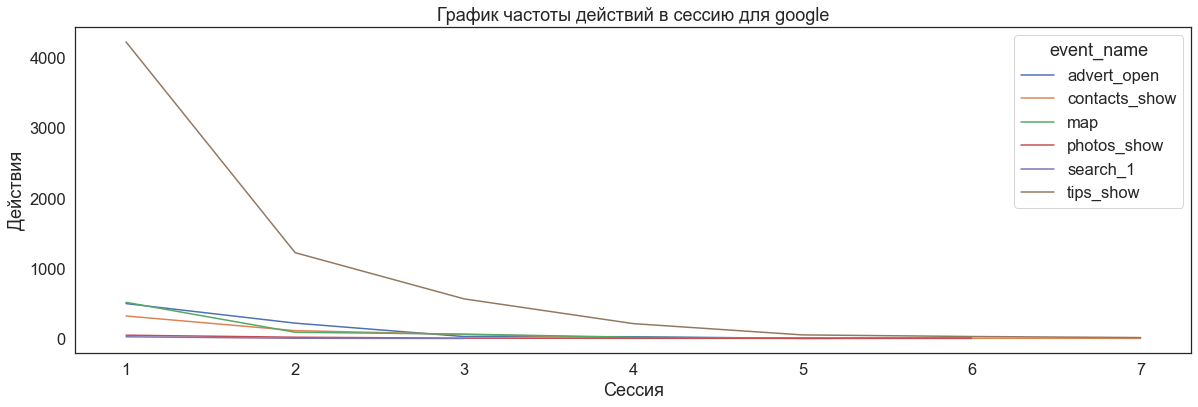

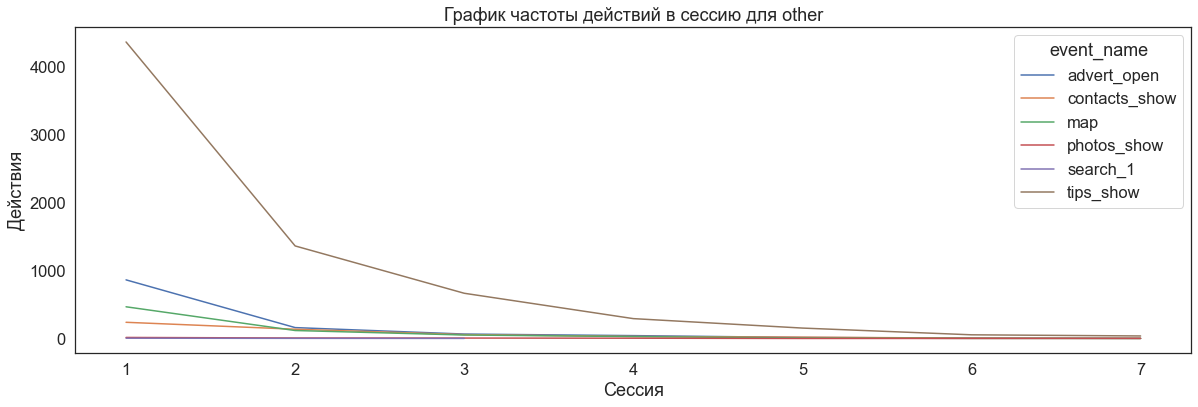

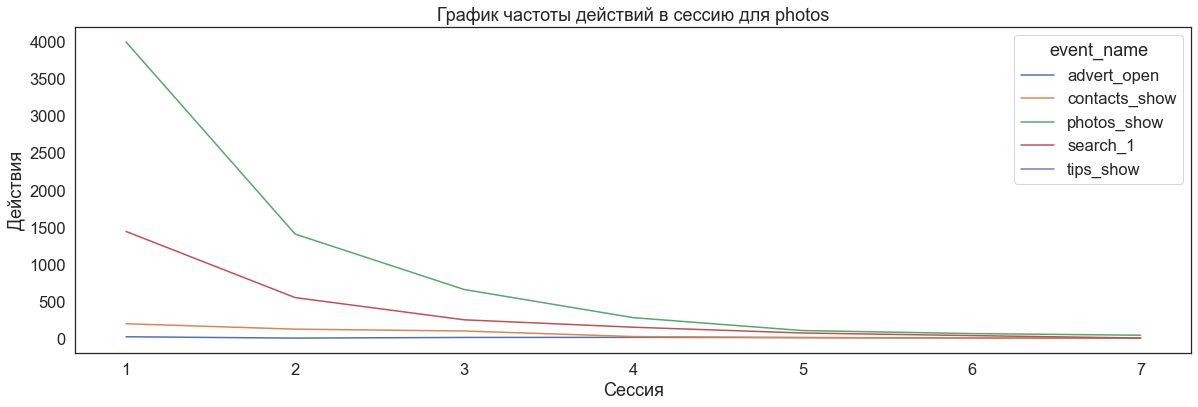

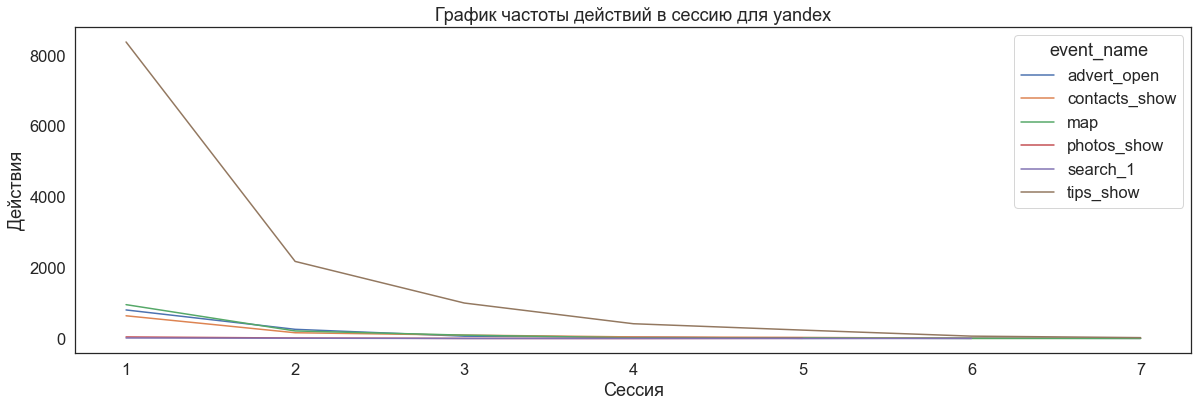

In [48]:
for col in event_session_data['cluster'].unique().tolist():
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.lineplot(
        data=event_session_data[event_session_data['cluster']==col],
        x='session',
        y='events',
        hue='event_name'
    )
    
    plt.title(f'График частоты действий в сессию для {col}')
    plt.xlabel('Сессия')
    plt.ylabel('Действия')
    plt.show();

Графики согласуются с предыдущими наблюдениями.
- Пользователи из `google` активны, в основном, смотрят рекомендации. Открывают карточки товара, смотрят карту, фото.

- Пользователи из `other` смотрят рекомендации и чаще открывают карточки объявлений. Смотрят карту и контакты.

- В `photos` предсказуемо сплошные просмотры фото. А так же много поиска, немного просмотра контактов.

- Пользователи из `yandex` тоже любят смотреть рекомендации, но и остальная активность присутствует в равной мере.

### Наблюдения

В общем, во всех кластерах, проме `photos` чаще всего просматривают рекомендации. Около 4 рекомендаций на человека. В остальном распределение такое:

- Пользователи из `google` совершают больше всех действий. Почти половина открывает контакты, больше всех.

- Пользователи из `other` почти каждый раз открывают карточку объявления. Просматривает контакты каждый третий.

- Пользователи из `photos` совершают меньше всего действий. Но каждый смотрит почти 3 фотографии, каждый пользуется поиском, а смотрит контакты только каждый пятый, меньше всех.

- Пользователи из `yandex`  открывают карточки объявлений и карту. Смотрят больше всех рекомендации. Открывают контакты меньше половины пользователей.

## Конверсия в целевое действие — просмотр контактов

### Разделить клиентов по целевому действию
Подготовим данные.

In [49]:
first_ts_data = (
    data_features
    .groupby(['user_id', 'cluster', 'source'])
    .agg(first_ts=('event_time', np.min))
    .reset_index()
)

first_ts_data['first_ts'] = first_ts_data['first_ts'].dt.date

event_first_data = (
    data_features[['user_id', 'event_name', 'event_time']]
    .groupby(['event_name', 'user_id'])
    .agg(event_dt=('event_time', np.min))
    .reset_index()
    .rename(columns={'first_ts':'event_first'})
)

event_first_data['event_dt'] = event_first_data['event_dt'].dt.date

profile_raw = first_ts_data.merge(event_first_data, on='user_id', how='inner')

display(profile_raw)

,user_id,cluster,source,first_ts,event_name,event_dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,other,2019-10-07,map,2019-10-09
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,other,2019-10-07,tips_show,2019-10-07
2,00463033-5717-4bf1-91b4-09183923b9df,photos,yandex,2019-11-01,photos_show,2019-11-01
3,00551e79-152e-4441-9cf7-565d7eb04090,photos,yandex,2019-10-25,contacts_show,2019-10-25
4,00551e79-152e-4441-9cf7-565d7eb04090,photos,yandex,2019-10-25,photos_show,2019-10-29
...,...,...,...,...,...,...
7053,ffcf50d9-293c-4254-8243-4890b030b238,google,google,2019-10-23,map,2019-10-23
7054,ffcf50d9-293c-4254-8243-4890b030b238,google,google,2019-10-23,tips_show,2019-10-23
7055,ffe68f10-e48e-470e-be9b-eeb93128ff1a,photos,yandex,2019-10-21,contacts_show,2019-10-22
7056,ffe68f10-e48e-470e-be9b-eeb93128ff1a,photos,yandex,2019-10-21,photos_show,2019-10-21


Посчитаем количество уникальных юзеров, совершивших целевое действие.

In [50]:
def conversion_cluster(event):

    profile_raw_total = (
        profile_raw
        .groupby('cluster')
        .agg({'user_id':'nunique'})
        .reset_index()
        .rename(columns={'user_id':'total'})
    )

    profile_raw_contacts = (
        profile_raw[profile_raw['event_name']==event]
        .groupby('cluster')
        .agg({'user_id':'nunique'})
        .reset_index()
        .rename(columns={'user_id':'event_total'})
    )

    conversion_cluster = profile_raw_total.merge(profile_raw_contacts, on='cluster')

    conversion_cluster['conversion, %'] = (conversion_cluster['event_total'] / conversion_cluster['total'] * 100).round(2)

    return conversion_cluster

Получили данные по целеевому действию. Посчитаем конверсию.

### Посчитать конверсию для групп

In [51]:
conversion_contacts_show = conversion_cluster('contacts_show')

display(conversion_contacts_show.sort_values('conversion, %', ascending=False))

,cluster,total,event_total,"conversion, %"
2,photos,1056,244,23.11
3,yandex,1338,293,21.90
0,google,691,144,20.84
1,other,860,136,15.81


### Наблюдения

Наибольшую конверсию в просмотр контактов 23% показывает кластер `photos`. Далее, с небольшим отрывом `yandex` и `google`, а вот `other` сильно отстали с конверсией 16%.

## Выводы по группировке

Разделение по группам произошло на основе каналов привлечения и целевых действий. Одна группа `photos` состоит из пользователей, которые смотрят фотографии и используют поиск, в отличие от других групп, где этих действий нет или крайне мало. Группы по каналу привлечения мало отличаются друг от друга.

- Пользователи из `photos` совершают меньше всего действий. Но каждый смотрит почти 3 фотографии, каждый пользуется поиском, а смотрит контакты только каждый пятый, меньше всех. Так же у них самая высокая конверсия.

- Пользователи из `yandex`  открывают карточки объявлений и карту. Смотрят больше всех рекомендации. Открывают контакты меньше половины пользователей. Самая многочисленная группа со средней конверсией. 

- Пользователи из `other` почти каждый раз открывают карточку объявления. Просматривает контакты каждый третий. Самая низкая конверсия из всех групп.

- Пользователи из `google` совершают больше всех действий. Почти половина открывает контакты, больше всех. Самая малочсиленная группа, но со средней конверсией.

# Проверка гипотез

## Гипотеза 1: две группы (по каналу привлечения) демонстрируют разную конверсию в просмотры контактов

Из прошлой таблицы видно, что конверсия в данной выборе разная у пользователей из Яндекс и Гугл, но  близкая.

In [52]:
display(conversion_contacts_show.sort_values('conversion, %', ascending=False))

,cluster,total,event_total,"conversion, %"
2,photos,1056,244,23.11
3,yandex,1338,293,21.90
0,google,691,144,20.84
1,other,860,136,15.81


### Проверить гипотезу т-тестом

In [53]:
def z_test(data, cluster1, cluster2, alpha=0.05):
    
    successes1 = data[data['cluster'] == cluster1]['event_total'].tolist()[0]
    successes2 = data[data['cluster'] == cluster2]['event_total'].tolist()[0]
    trials1 = data[data['cluster'] == cluster1]['total'].tolist()[0]
    trials2 = data[data['cluster'] == cluster2]['total'].tolist()[0]
    
    p1 = successes1 / trials1
    p2 = successes2 / trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    print('p-значение: ', p_value)

    if (p_value < alpha): 
        print('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [54]:
z_test(conversion_contacts_show, 'yandex', 'google')

p-значение:  0.5823836009691976
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет


Судя по тесту, статистически значимых различий в выборках нет.

## Гипотеза 2: две группы (по каналу привлечения) демонстрируют разную конверсию в открытие карточки объявления

Посчитаем конверсию в открытие карточки объявления.

In [55]:
conversion_advert = conversion_cluster('advert_open')

conversion_advert

,cluster,total,event_total,"conversion, %"
0,google,691,143,20.69
1,other,860,223,25.93
2,photos,1056,35,3.31
3,yandex,1338,223,16.67


Небольшая разница между Яндекс и Гугл имеется, посмторим, насколько значимая.

In [56]:
z_test(conversion_advert, 'yandex', 'google')

p-значение:  0.025339358669884682
Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия


Разница в конверсии в открытие карточки объявления оказалась значимой.

## Выводы по гипотезам

Судя по тестам, статистически значимые различия конверсий для групп `yandex` и `google` отсутствуют в просмотр контактов, но есть в открытие карточки объявления.

# Выводы и рекоменадции

Исследование проводилось в течение 28 дней по данным пользователей, впервые совершивших действия в приложении после 7 октября 2019 года. Датасеты имеют хорошую структуру, без пропусков и дубликатов. Небольшая очистка требуется только для улучшения картины анализа.

Пользователей можно разделить на 4 сегмента:

- Пользователи из `photos` совершают меньше всего действий. Но каждый смотрит почти 3 фотографии, каждый пользуется поиском, а смотрит контакты только каждый пятый, меньше всех. Так же у них самая высокая конверсия. Стабильно выше активность по выходным.

- Пользователи из `yandex`  открывают карточки объявлений и карту. Смотрят больше всех рекомендации. Открывают контакты меньше половины пользователей. Самая многочисленная группа со средней конверсией. 

- Пользователи из `other` почти каждый раз открывают карточку объявления. Просматривает контакты каждый третий. Самая низкая конверсия из всех групп. Низкая активность по выходным, но высокая в начале недели.

- Пользователи из `google` совершают больше всех действий. Почти половина открывает контакты, больше всех. Самая малочсиленная группа, но со средней конверсией. Активность часто наблюдается в начале недели.

Инсайты:
- Чаще всего юзеры заходят в приложение полистать рекомендации.
- Картой пользуется меньшинство.
- Есть кластер пользователей, пришедших по прямой ссылке на объявление, они не часто остаются.
- Есть кластер пользователей, которые, в основном, смотрят фотографии. У них самая высокая конверсия.
- Пользователи из кластеров Яндекс и Google мало чем отличаются.

Совету по улучшению приложения:

- Возможно, небольшой спрос на поиск связан с неудобством пользования им.
- Пользователи крайне редко пользуются картой, возможно стоит переработать её или вовсе убрать.
- Стоит сделать акцент на рекомендованных объявлениях, на их просмотр пользователи готовы тратить больше всего времени.